In [ ]:
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import tqdm
import sys
import numpy as np
import sklearn 
import warnings
warnings.filterwarnings(action='once')
from scib_metrics.benchmark import Benchmarker

sc.settings.figdir=os.path.expanduser('~/WbFigures/ImmuneIntegrations')

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis

In [ ]:
import scanorama
import pyliger
from harmony import harmonize

In [ ]:
adata=sc.read_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/1.9.1.8.1_Immune/p3_adata.h5ad')

In [ ]:
out_reductions='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/ImmuneIntegrations'

In [ ]:
batch_key='batch'
discov_key='species'
layer_key='counts'
MDE_KEY = "X_antipode_MDE"

In [17]:
adata

AnnData object with n_obs × n_vars = 97861 × 8135
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'species', 'study', 'tissue', '_scvi_discov_ind', '_scvi_batch_ind', 'psi_0', 'psi_1', 'psi_2', 'q_score', 'level_0', 'level_1', 'level_2', 'antipode_cluster', 'kmeans', 'species_chemistry'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'antipode_cluster_colors', 'batch_colors', 'kmeans_colors', 'level_0_colors', 'level_1_colors', 'level_2_colors', 'param_store', 'species_colors', 'species_chemistry_colors'
    obsm: 'X_antipode', 'X_antipode_MDE', 'discov_onehot', 'kmeans_onehot', 'taxon_probs'
    layers: 'counts'

In [ ]:
adata.obs['species_chemistry']=adata.obs['chemistry'].astype(str)+adata.obs['species'].astype(str)

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/scanpy/lib/py

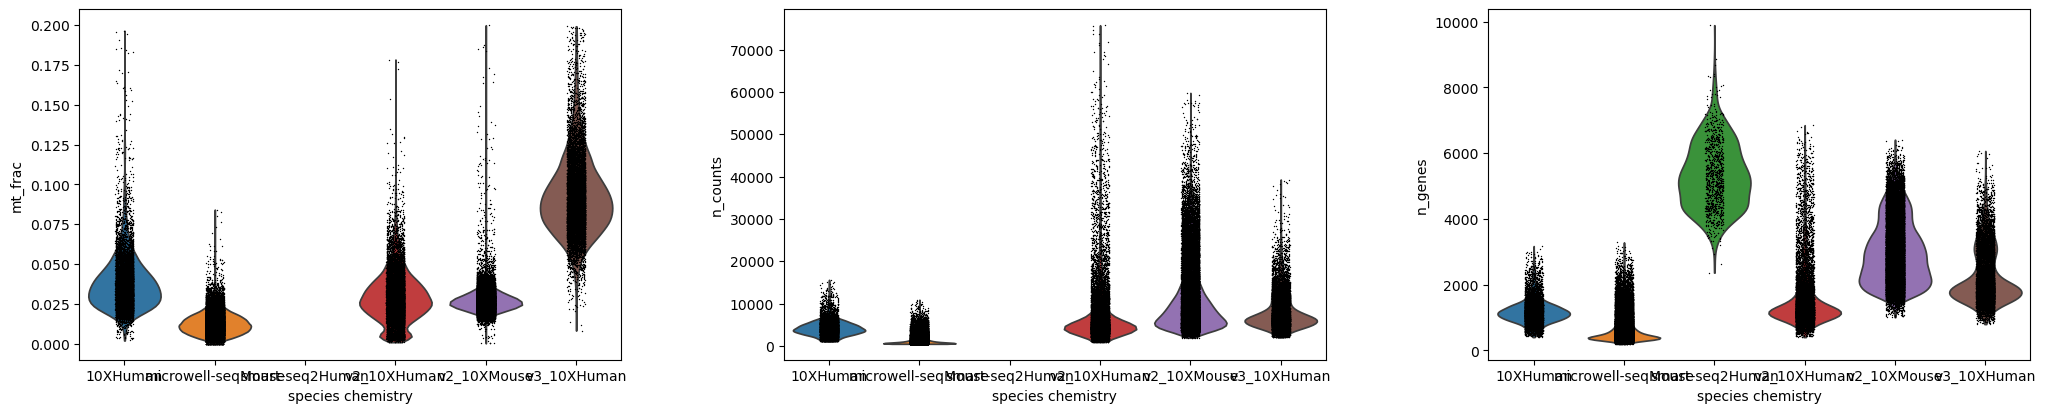

In [19]:
sc.pl.violin(adata,groupby='species_chemistry',keys=['mt_frac', 'n_counts', 'n_genes'])

In [ ]:
%%time
import scvi
#adata=sc.read_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/1.9.1.8.1_PsiNormal-Smallerencoder-Tighter-final/p4_adata.h5ad',backed='r')
scvi_model=scvi.model.SCVI.load('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/SCVI_Dev.scvi',adata=adata) 
SCVI_LATENT_KEY = "X_SCVI"
print('loaded')
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation(adata)

np.savetxt(os.path.join(out_reductions,"X_SCVI.csv"), adata.obsm["X_SCVI"], delimiter=",")

In [ ]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[discov_key],legend_fontsize=6,legend_fontweight='normal',
    palette=sc.pl.palettes.godsnot_102
)

In [ ]:
sc.pp.scale(adata,zero_center=False)

In [ ]:
sc.pp.pca(adata)

In [ ]:
%%time

adata.obsm["X_harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key=discov_key)

In [ ]:
%%time

# List of adata per batch
batch_cats = adata.obs[discov_key].cat.categories
adata_list = [adata[adata.obs[discov_key] == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["X_Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["X_Scanorama"][adata.obs[discov_key] == b] = adata_list[i].obsm["X_scanorama"]


In [ ]:
%%time

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["spliced"]
# List of adata per batch
batch_cats = adata.obs[discov_key].cat.categories
adata_list = [bdata[bdata.obs[discov_key] == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["X_liger"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["X_liger"][adata.obs[discov_key] == b] = liger_data.adata_list[i].obsm["H_norm"]


In [ ]:
obsm_keys=["X_pca", "X_Scanorama", "X_liger", "X_harmony", "X_SCVI", "X_antipode"]
obsm_keys=[x for x in obsm_keys if x in adata.obsm.keys()]

In [ ]:
for x in obsm_keys:
    try:
        np.savetxt(os.path.join(out_reductions,x+".csv"), adata.obsm[x], delimiter=",")
    except:
        print(x,'FAILED')


In [ ]:
adata

In [ ]:
obsm_keys=["X_pca", "X_Scanorama", "X_liger", "X_harmony", "X_SCVI", "X_antipode"]
for x in obsm_keys:
    print(x)
    try:
        adata.obsm[x]=np.loadtxt(os.path.join(out_reductions,x+".csv"), delimiter=",")
    except:
        print(x,'FAILED')

In [ ]:
adata

In [ ]:
obsm_keys=[x for x in obsm_keys if x in adata.obsm.keys()]
xdata=sc_analysis.select_k_cells(adata,'level_2',10000)
output_dir=os.path.join(sc.settings.figdir,'level_2')
try:
    os.mkdir(output_dir)
except:
    pass
bm = Benchmarker(
    xdata,
    batch_key="batch_name",
    label_key="level_2",
    embedding_obsm_keys=obsm_keys,
    n_jobs=1,
)
bm.benchmark()
bm.plot_results_table(save_dir=output_dir)
bm.plot_results_table(save_dir=output_dir,min_max_scale=False)

In [ ]:
df = bm.get_results(min_max_scale=False)
df.to_csv(os.path.join(output_dir,'scib-metrics.csv'))

In [ ]:
def taxonomy_entropy(anndata, annotations, nearest_neighbors = 15, dim = "X_scVI"):
    """Compute entropy (mixing) of annotations within a cells local neighborhood. 
    Author: Nelson Johansson
    Args:
        anndata (.h5ad): anndata object with `annotations` in anndata.obs.
        annotations (list of str): Cell level annotations.
        nearest_neighbors (int): Number of nearest neighbors.
        dim (str): Dimensionality reduction within anndata.obsm. Should be "X_scVI" but can be "X_umap".
    Example:
        adata = sc.read_h5ad("YOUR_ANNDATA.h5ad")
        adata = taxonomy_entropy(anndata = adata, annotations=["Neighborhood", "Subclass"])
    Returns:
        anndata
    """
    ## Build nearest neighbor tree for fast lookup
    print("Building nearest neighbor tree.")
    nnTree = sklearn.neighbors.KDTree(anndata.obsm[dim])
    nearest_dist, nearest_ind = nnTree.query(anndata.obsm[dim], k=nearest_neighbors)
    ##
    for anno in annotations:
        print("Computing entropy on: " + anno)
        anndata.obs[anno + "_entropy"] = -1 ## Initialize with a value outside range of entropy.
        for cell in tqdm.tqdm(range(0, anndata.shape[0])):
            nearest_neighbors = nearest_ind[cell,:]
            anndata.obs.loc[anndata.obs.index[cell], anno + "_entropy"] = scipy.stats.entropy(anndata.obs.loc[anndata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
    return anndata


In [ ]:
for x in obsm_keys:
    try:
        taxonomy_entropy(xdata,['species','batch_name'],nearest_neighbors = 30,dim=x)
    except:
        print(x,'FAILED')

In [ ]:
adata.obs[:,['species_entropy','batch_name_entropy']].to_csv(os.path.join(sc.settings.figdir,'entropy_table.csv'))